<h1><center>Estimation du prix de l'immobilier</center></h1>

<h4><center>Projet réalisé par Aké Esso KAMOUNA et Athêna BRISSE</center></h4>


<h2><center>1-Introduction</center></h2>


Prédire le prix d'une maison représente une avancée et une perspective considérables face aux enjeux du monde de l'immobilier. Il est en effet primordial pour quiconque possède un bien de pouvoir estimer sa valeur. Et grace au machine learning, il est possible d'aggréger différentes informations telles que la superficie du bien immobilier, sa localisation, son année de rénovation et bien d'autres particularités pour avoir une estimation fidèle de son prix de vente. C'est l'objet de notre projet. Nnous voyageons aux Etats-Unis, dans le comté de King –  État de Washington – afin de prédire le prix de vente des maisons.


Après une exploration des données afin de nous familiariser avec, nous utilisons différents modèles de régression, ce projet s'inscrivant dans le cadre d'un cours dont nous voulions mettre à profit les apprentissages. Raffinés manuellement ou non, nous les comparons. En prenant en compte le temps de computation et les difficultés pratiques inhérentes à certains modèles, nous tentons de sélectionner celui qui obtient les meilleures performances

On va essayer de comprendre les facteurs déterminants dans la hausse du prix de vente, et tenter, comme le font désormais de nombreuses entreprises immobilières, de prédire ce prix avec la plus grande précision possible. 

<h2><center>2- Le dataset utilisé</center></h2>

Le dataset est constitué d'informations concernant 21613 maisons vendues entre mai 2014 et mai 2015. 


Pour donner un peu de détail, le dataset est composé de 21613 observations, de 21 variables chacunes.


*   id : Notation d'une maison
*   date : Date de vente de la maison
*   bedrooms : Nombre de chambres
*   bathrooms : Nombre de salles de bain
*   sqft_living  : Surface de la maison (square feet)
*   sqft_lot  : Surface du terrain (square feet)
*   sqft_above : Superficie de la maison hors sous-sol
*   sqft_basement : Superficie du sous-sol
*   floors  : Nombres d’étages 
*   waterfront  : Vue sur la  mer
*   vue  : Annonce qui a été vue 
*   condition : État général de la maison
*   note  : note globale attribuée à l’habitation, sur la base du système de notation du King County
*   yr_built : Année de construction
*   yr_renovated : Année de rénovation de la maison
*   zipcode : Code postal
*   lat : Latitude
*   long : Longitude
*   price Le prix est l'objectif de la prédiction
*   sqft_living15 : Surface de la salle de séjour en 2015. Cela implique de potentielles rénovations qui pourraient ou non avoir affecté la surface du lot.
*   sqft_lot15 : Surface du terrain en 2015 (implique de potentielles rénovations



 <h2><center>3- Les librairies utilisées</center></h2>

In [118]:
import os 
import pandas as pd 
import numpy as np 
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import * 
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from scipy.stats import norm,skew,kurtosis
from xgboost import XGBRegressor
import time
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
import warnings
from sklearn import metrics
warnings.filterwarnings('ignore')

<h2><center> 4- Un peu d'analyse exploratoire</center></h2> 

In [1]:
#data=pd.read_csv("/datasets/kc_house_data.csv")
#data.head()

In [98]:
data.drop(["date","id"],axis=1,inplace=True)
data['price'].describe()

count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Le prix minimum est supérieur à 0. Pas d’incohérence de ce point de vue là, nous poursuivons. 


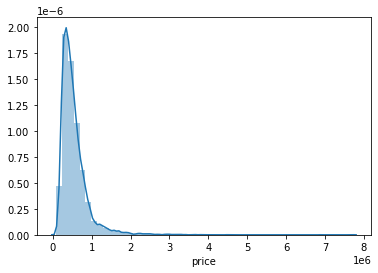

In [92]:
sns.distplot(data['price'])

Cette distribution montre que les prix s’écartent de la distribution normale. 
Cette distribution présente un pics avec une asymétrie positive. Pour réduire le risque de mauvaises prédictions, il nous paraît préférable d'approximer la distribution des données par une loi normale.



In [93]:
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

Skewness: 4.024069
Kurtosis: 34.585540


La Skewness est positive : les données sont inclinées vers la droite, donc vers un prix plus élevé. La Kurtosis montre une valeur extrêmement élevée, qui peut être expliquée par la queue de distribution assez conséquente, avec des prix qui peuvent monter jusque très haut. 
D'après le graphiques ci-dessus, on peut voir que très peu de maisons présentent des prix très éloignés des autres, comme un prix d'environ 7 000 000 dollars. De plus, l’on peut imaginer que dans des ensembles de données réels, il y aura toujours des valeurs aberrantes, comme les prix des maisons de luxe. C'est pourquoi on décide de ne pas supprimer les valeurs aberrantes.


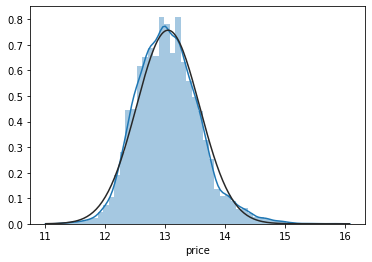

In [94]:
data['price'] = np.log1p(data['price'])
sns.distplot(data['price'],fit=norm)

In [95]:
print("Skewness: %f" % data['price'].skew())
print("Kurtosis: %f" % data['price'].kurt())

Skewness: 0.428077
Kurtosis: 0.691857


La Skewness et la Kurtosis sont bien proches de zéro, ce qui est bon signe dans l'optique de normalisation dans laquelle nous sommes. 

 <h4><center>4.1 Relation Prix et autres variables </center></h4>  

 <h4><center>Variables continues</center></h4> 

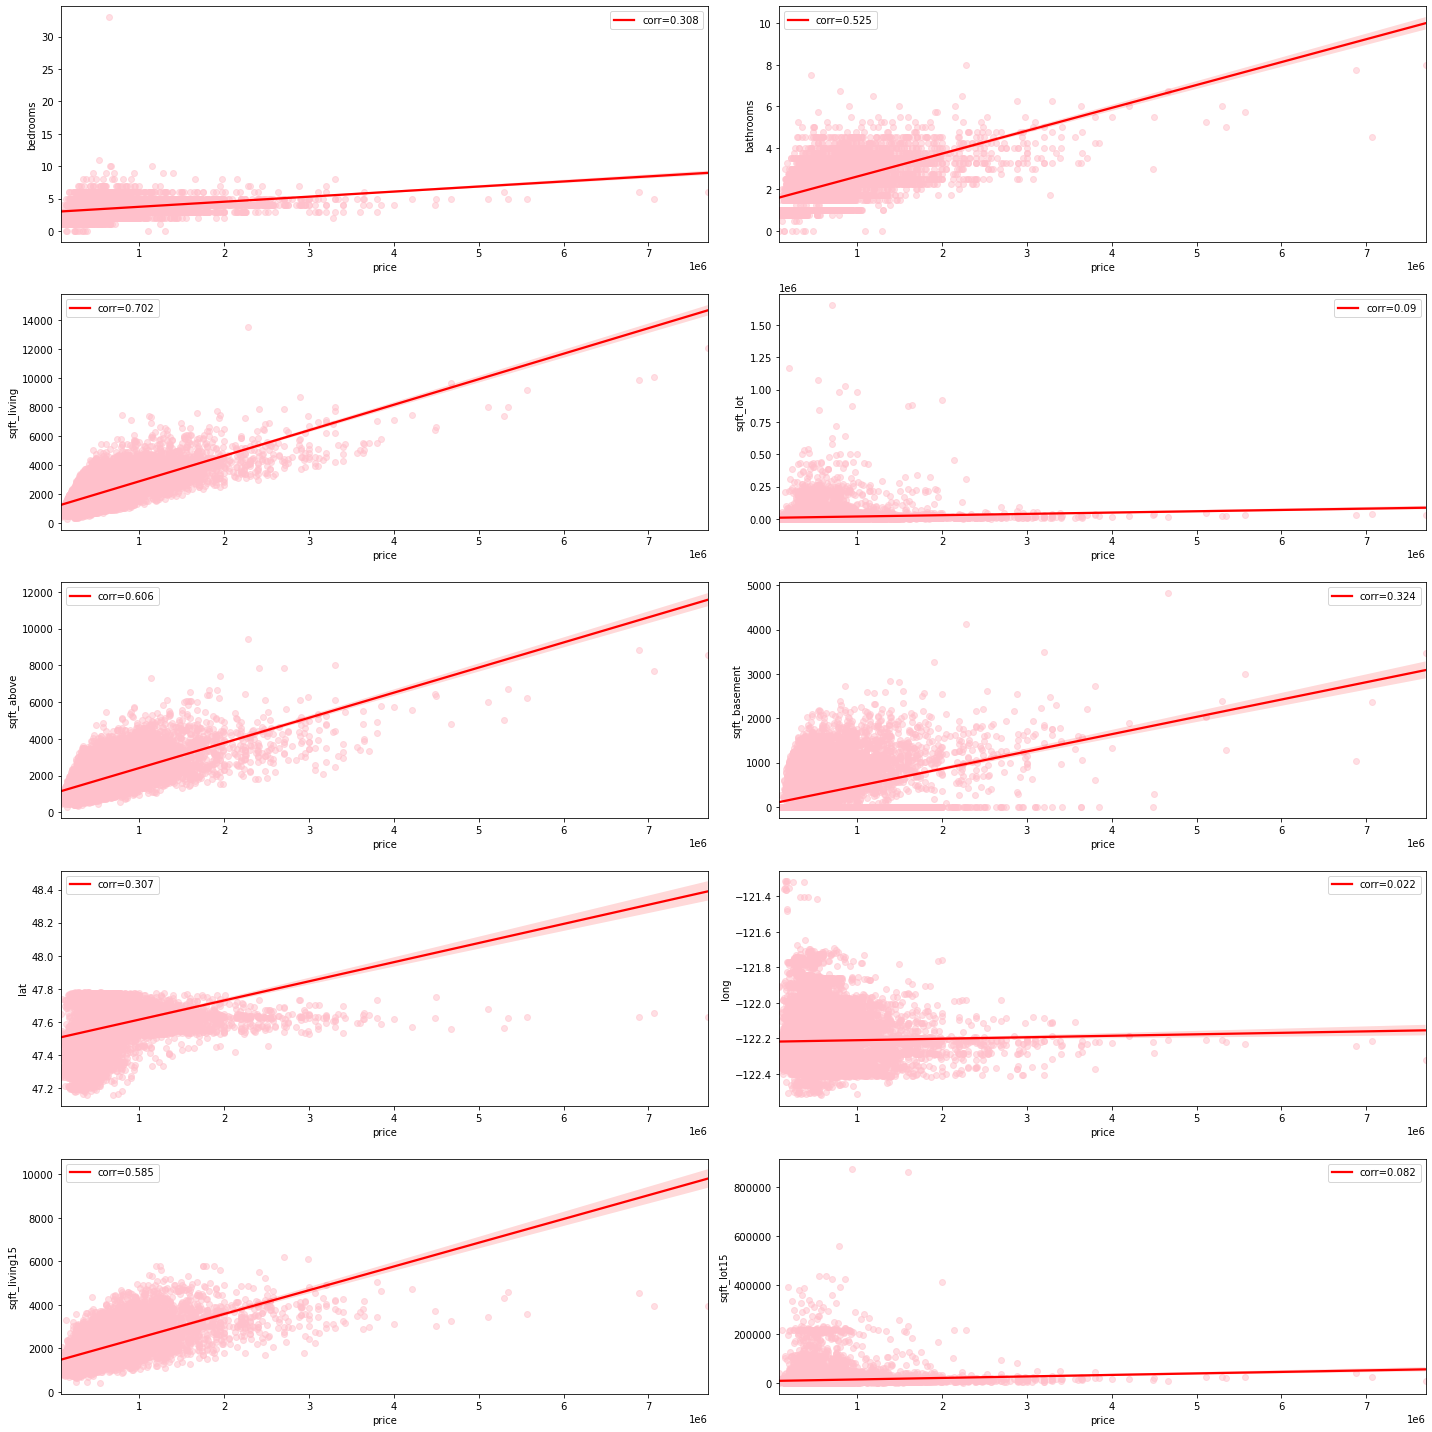

In [99]:
fig , axs = plt.subplots(nrows=5 , ncols=2 , figsize=(20, 20))
axs = axs.ravel()

for i , col in enumerate(data.columns.drop(['yr_renovated',
                                            'zipcode', 'condition','grade',
                                            'price','waterfront','floors','yr_built','view'])) :
    sns.regplot(data=data , x='price' , y=col ,scatter_kws={'alpha':0.5 , 
                                                            'color' : 'pink'},
                line_kws={'color' : 'red'} , ax=axs[i])
    corr = data.corr().sort_values('price')['price'].loc[col].round(3)
    axs[i].legend([f'corr={corr}'])
plt.tight_layout()

D'après ce qui précède, nous pouvons constater que la superficie au-dessus du sol (sqft_above), la note globale attribuée au logement (grade) et la superficie de la maison (sqft_living) sont les caractéristiques qui sont les plus corrélées avec le prix des maisons.

Ils semblent reliés linéairement entre eux.

 <h4><center>Variables discretes</center></h4> 

Pour déterminer le nombre de chambres, d'étages ou de salles de bain/chambres par rapport au prix, on préfère utiliser des boxplot car nous avons des données numériques mais elles ne sont pas continues comme 1,2,... chambres, 2.5, 3,... étages (probablement 0.5 pour le penthouse).

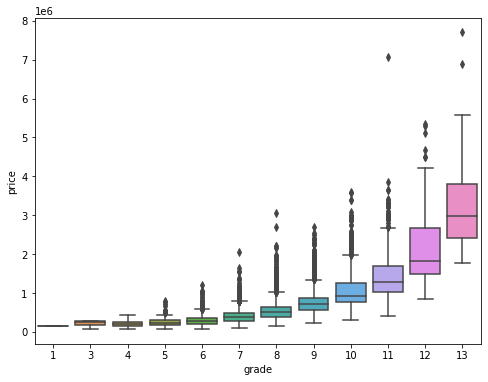

In [100]:
var = 'grade'
dat = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=dat)

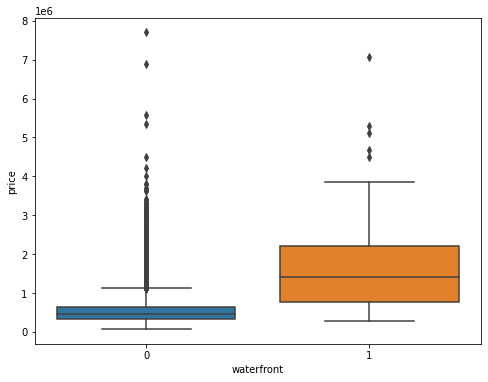

In [101]:
var = 'waterfront'
dat = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=dat)

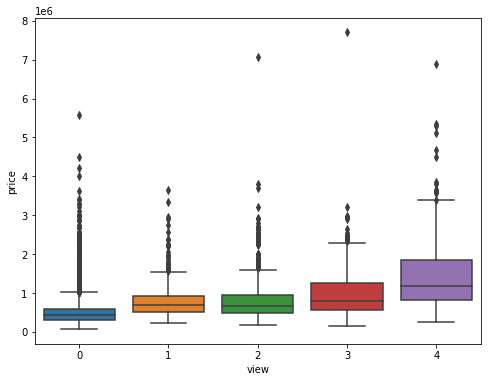

In [102]:
var = 'view'
dat = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=dat)

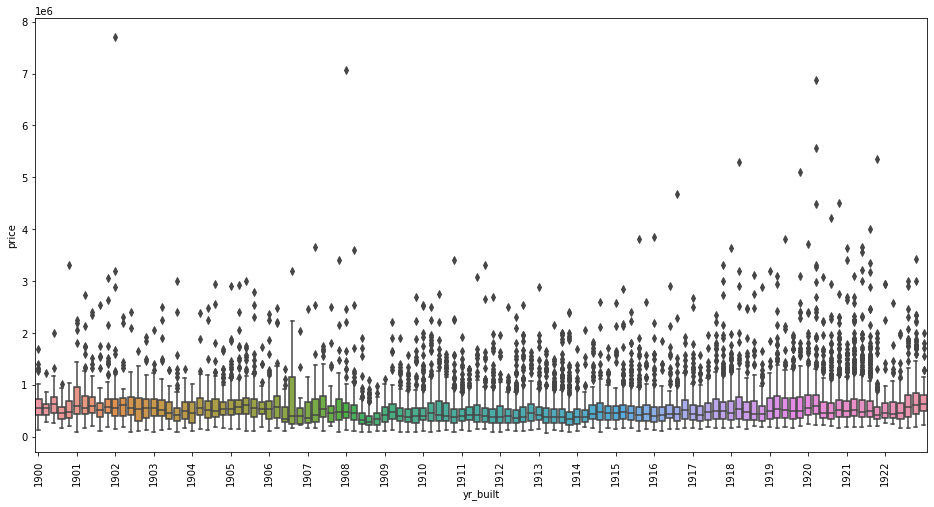

In [103]:
var = 'yr_built'
dat = pd.concat([data['price'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="price", data=dat)
plt.xticks(np.arange(0, 112, 5),rotation=90);


Si nous regardons les diagrammes ci-dessus, la note et le front de mer affectent visiblement le prix. En ce qui concerne la note (grade), le prix a l’air relié de façon linéaire puis de façon beaucoup plus radicale, presque exponentiel, à partir d’un certain seuil : la note 10 environ. 
La vue semble également avoir un effet sur le prix, mais de façon plus réduite.

Enfin, l'année de construction n'a pas d'incidence déterminante sur le prix.


   <h4><center>4.2- Correlations entre variables</center></h4>  

<Figure size 720x432 with 0 Axes>

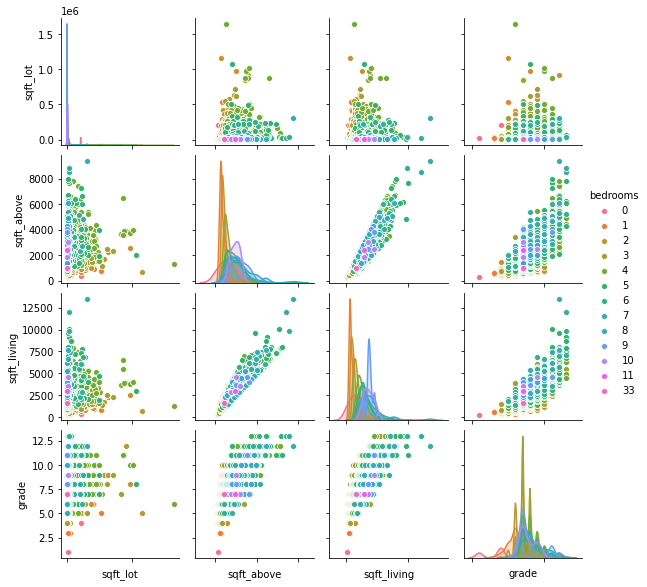

In [104]:
plt.figure(figsize=(10,6))
sns.plotting_context('notebook',font_scale=1.2)
g = sns.pairplot(data[['sqft_lot','sqft_above',
                       'sqft_living','bedrooms','grade']]
                 ,hue='bedrooms',height=2)
g.set(xticklabels=[])

S'il y a une corrélation très élevée entre deux caractéristiques, les garder toutes les deux n'est pas une bonne idée, cela peut causer de l'overfitting. Par exemple, en cas d'overfitting, nous pouvons supprimer sqt_above ou sqt_living parce qu'ils sont fortement corrélés. Cette relation peut être estimée lorsque nous examinons la signification des variables, mais pour être sûr, il faut vérifier la matrice de corrélation. 


 <h4><center>Heatmap</center></h4> 

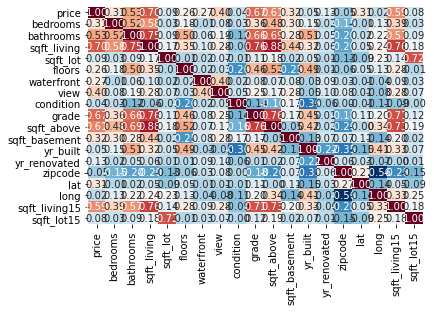

In [105]:
sns.heatmap(data=data.corr() , 
            annot=True ,  fmt='.2f' , cbar=False , cmap='RdBu_r')

Nous avons une visualisation claire des données les plus corrélées. Nous retrouvons les fortes corrélations observées auparavent et en découvrons d'autres, notamment sqft_living15, grade et sqft_above, que nous interprétons ainsi : plus l'espace est grand, plus la note est meilleure. Cependant, il faut prendre garde à ne pas supprimer automatiquement deux variables corrélées. Par exemple : le nombre salles de bains (bedrooms) et sqft_living  sont fortement corrélés mais la relation entre eux n’est pas la même que celle entre sqft_living et sqft_above qui semblent bien plus proches dans leur définition. 


   <h3><center>5- Les modèles de machine learning</center></h3>

<h4><center>La regression linéaire avec toutes les variables</center></h4> 

In [106]:
features = data.drop('price' , axis=1)
target = data['price']
X_train , X_test , y_train , y_test = train_test_split(features , 
                                                       target , test_size=0.15, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

On met les données à échelle. 

Dans la régression, il est souvent recommandé de centrer les variables de sorte que les prédicteurs aient une moyenne de 0. Il est ainsi plus facile d'interpréter le terme d'intercept comme la valeur attendue de 𝑌𝑖 lorsque les valeurs des prédicteurs sont fixées à leurs moyennes. Sinon, l'intercept est interprété comme la valeur attendue de 𝑌𝑖 lorsque les prédicteurs sont fixés à 0, ce qui peut ne pas être une situation réaliste ou interprétable.

De plus, dans le cas ou un des prédicteurs a une grande échelle, les coefficients de régression peuvent être d'un très petit ordre de grandeur, ce qui peut être un peu gênant lorsque l'on lit les résultats de l'ordinateur.

In [107]:
model = LinearRegression()
model_name = "Linear Regression"
model.fit(X_train , y_train)
prediction = model.predict(X_test)
    
r2 = r2_score(prediction , y_test)
mae = mean_absolute_error(prediction , y_test).round(2)
    
print(f'{model_name} R2 = {r2}')
print(f'{model_name} MAE = {mae}')

Linear Regression R2 = 0.5629698017727498
Linear Regression MAE = 124070.17


Le modèle explique au maximum près de 70% de la variation totale du modèle. On le voit en regardant le coefficient R2, qui désigne le “Multiple R-squared".

**Rappel:**
Le MAE (Mean Average Error) évalue la distance absolue entre observations et prédictions, en prenant la moyenne sur toutes les observations. Nous utilisons la valeur absolue des distances afin que les erreurs négatives soient correctement prises en compte. On cherche à minimiser cette métrique.

Ici nous avons pris les 20 variables explicatives présentes. Avoir trop de variables dans un modèle n'est pas toujours une bonne chose car cela peut entraîner un surajustement et des résultats plus mauvais lorsque nous voulons prédire des valeurs pour un nouvel ensemble de données. Ainsi, si une variable n'améliore pas beaucoup notre modèle, ne pas l'ajouter peut être un meilleur choix. C’est pourquoi nous tentons de savoir dans quelle mesure nous pouvons nous passer de certaines variables en les sélectionnant à l’aide de deux critères.

 <h3><center>Selection des variables explicatives </center></h3>

Pour sélectionner les meilleurs sous-ensembles de variables explicatives dans la régression, il est possible de faire un choix descendant (pas à pas) de variables à la main. On enlèverait la variable la moins significative puis on recalculerait les estimations et ainsi de suite. Il existe **en R** un package qui traite du choix de variables : le package leaps. La fonction regsubsets retourne, pour différents critères (bic,  𝑅2, 𝑅2ajusté, Cp de Mallows, etc.), le meilleur modèle (si nbest=1) à 1 variable explicative, à 2 variables explicatives, ..., à nvmax variables explicatives. En d'autres termes, le code ajuste initialement les modèles avec la première variable en x, les deux premières, les trois premières, et ainsi de suite, et calcul le critère associé.

 <h3><center>Avec le critère R2a</center></h3>

**Rappel :**

Le 𝑅2𝑎 indique à quel point une ou plusieurs variables expliquent le pourcentage de variance de la variable d'intérêt (ici, le prix).

Le critère 𝑅2 tend à surévaluer la qualité de la régression linéaire. Sa valeur augmente avec le nombre d'effets. Le 𝑅2𝑎 tente de corriger cela, en diminuant si un effet spécifique n'améliore pas le modèle.

Le 𝑅2𝑎 est calculée en divisant la valeur moyenne de l'erreur quadratique du résidu par la valeur totale de l'erreur quadratique moyenne (qui correspond à la variance de l'échantillon à estimer). Le résultat est ensuite soustrait de 1.

La valeur du 𝑅2𝑎 est toujours inférieure ou égale à la valeur de 𝑅2. La valeur 1 indique un modèle qui prévoit parfaitement les valeurs du champ cible. Une valeur inférieure ou égale à 0 indique que le modèle n'a aucune capacité prédictive. En général, la valeur 𝑅2𝑎 se situe entre ces valeurs.



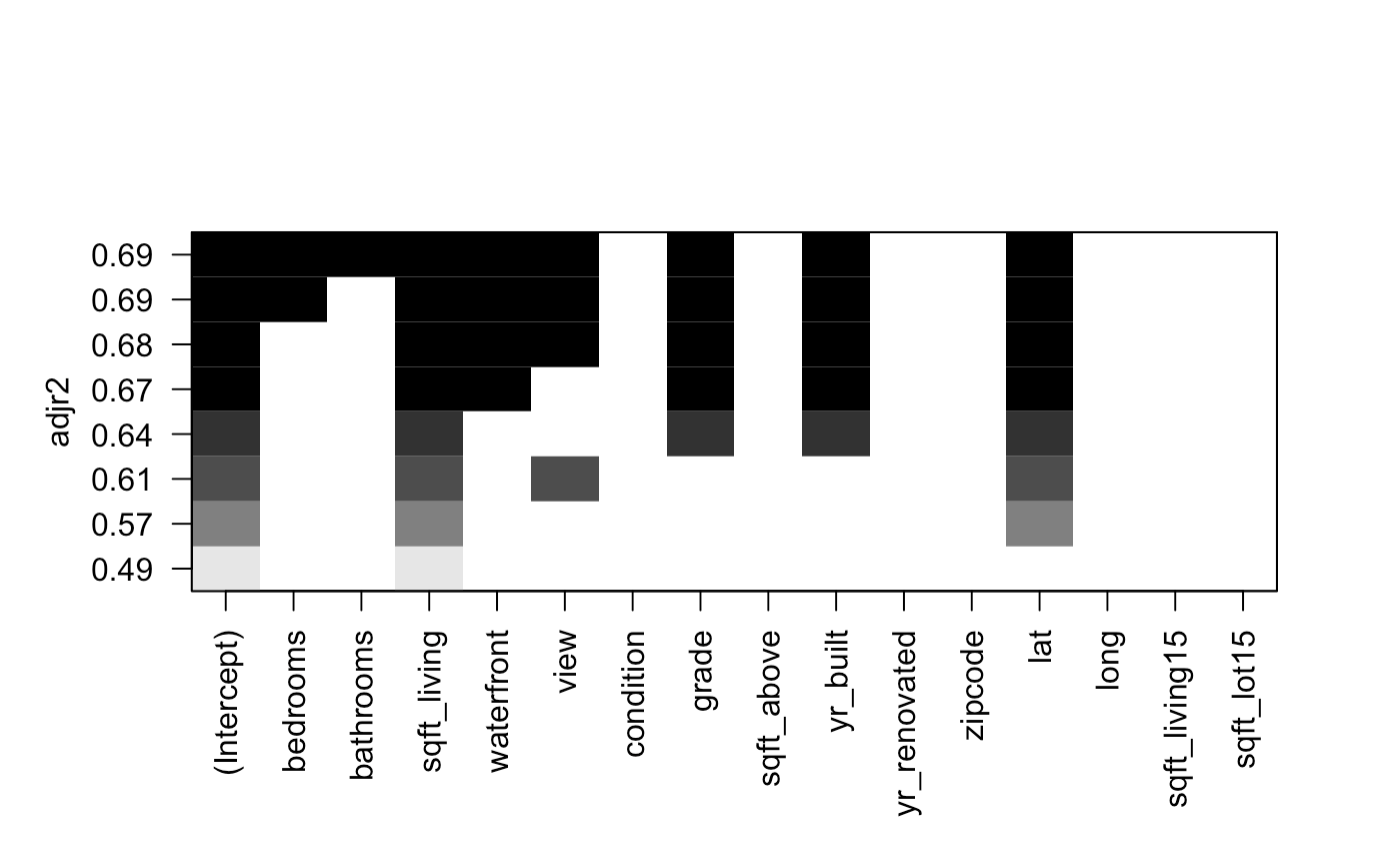

Le but est de maximiser le coefficient  𝑅2𝑎. Ici, le modèle qui performe le mieux contient :
*   la constante
*   bedroom
*   bathrooms
*   sqft_living
*   waterfront
*   view
*   grade
*   yr_built
*   lat

Note : on n'a pris que 15 des 20 variables explicatives. Nous avons effectués cette présélection grâce aux visualisations de corrélation montrés antérieurement.

### Pour le critère BIC

**Rappel : le criètre BIC**

Le BIC ou Schwartz’s information criterion a été développé par Gideon Schwarz en 1978.

Il est basé, en partie, sur la fonction de vraisemblance et est étroitement lié au critère d'information d'Akaike (AIC).

Lors de l'ajustement de modèles, il est possible d'augmenter la vraisemblance en ajoutant des paramètres, mais cela peut entraîner de l'overfitting. Le BIC tente de résoudre ce problème en introduisant un terme de pénalité pour le nombre de paramètres dans le modèle.

Formellement, 

BIC = k * ln(n)- 2 * ln(L) 

avec:
- k : nombre de paramètres à estimer. Ici, k = 15 + 1 + 1. 
- n : nombre d'observations
- L : maximum de la vraisemblance du modèle 

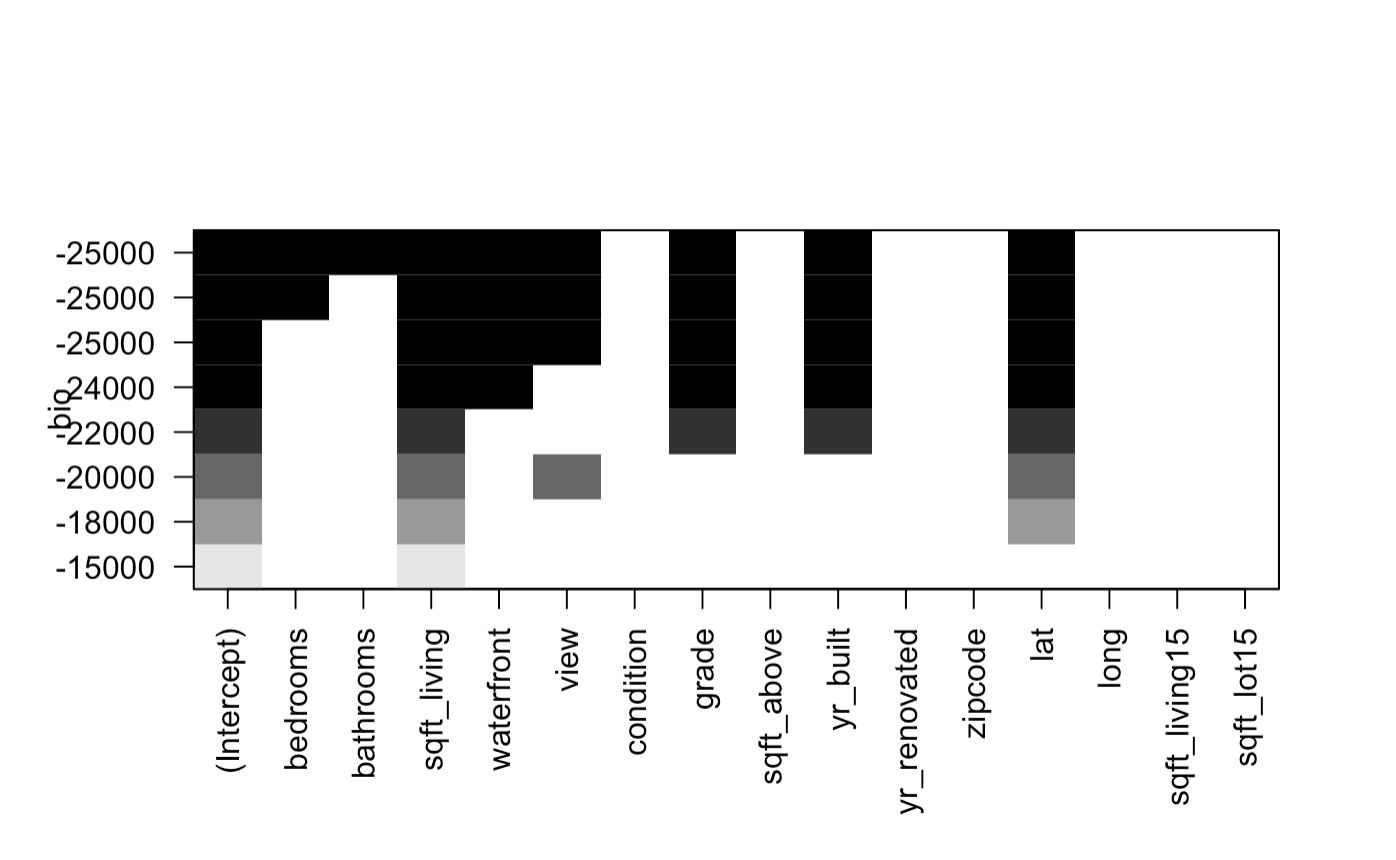

On cherche à minimiser le critère BIC. On choisit donc le modèle contenant: 
*   la constante
*   bedrooms
*   bathrooms
*   sqft_living
*   waterfront
*   view
*   grade
*   yr_built
*   lat

On retrouve les mêmes variables que celles obtenues avec le critère  𝑅2𝑎.
Effectuons un nouveau modèle de régression en ne prenant que ces variables.





 <h2><center>Regression linéaire avec variables sélectionnées</center></h2> 

In [108]:
features = data.drop(['price', 'view','condition','zipcode','long', 
                     'sqft_living15', 'sqft_lot15','floors',
                     'yr_renovated'],axis=1)
target = data['price']
X_train , X_test , y_train , y_test = train_test_split(features , 
                                                       target , test_size=0.15 , shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train , y_train)
prediction = model.predict(X_test)
    
r2 = r2_score(prediction , y_test)
mae = mean_absolute_error(prediction , y_test).round(2)
    
print(f'{model_name} R2 = {r2}')
print(f'{model_name} MAE = {mae}')

Linear Regression R2 = 0.5305815744955407
Linear Regression MAE = 129392.41


Lors de nos essais, le résultat était généralement égal ou moins bon. Ici, 67% des variations sont expliquées par les variables sélectionnées. 

Ce résultat n'est toutefois pas surprenant, dans la mesure où il n’y a pas un très grand nombre de variables explicatives. Et qu’à ce stade, les retirer revient plutôt à une perte d’informations qu’autre chose. Plus tard dans notre étude, on se penchera sur une PCA, pour savoir si certaines variables sont à privilégier ou non.


 <h2><center> La régularisation </center></h2> 

La régularisation est conçue pour résoudre le problème de l'overfitting et du underfitting. L'overfitting signifie une variance élevée, cette fonction s'adapte bien aux données d'apprentissage mais peut donner de mauvais résultats pour l'ensemble de test. D'autre part, l’underfitting signifie une faible variance et un modèle très simple. Cela peut également entraîner de mauvais résultats. Les remèdes possibles sont l'ajustement manuel des caractéristiques ou l'utilisation de certains algorithmes de sélection de modèles, ce qui entraîne une charge de travail supplémentaire. À l'inverse, lorsque nous appliquons la régularisation, toutes les caractéristiques sont conservées et le modèle ajuste θj . Cela fonctionne particulièrement lorsque nous avons beaucoup de caractéristiques légèrement utiles. Il existe deux types de régularisation largement utilisés (Ridge et Lasso) et dans cette section, on les a utilisées.


Généralement, on utilise la régression ridge quand il y beaucoup de variables explicatives d'importance moyenne. Et on utilise lasso quand il n'y a que peu de variables avec un effet important. Notre dataset ne se situe pas de façonn évidente d'un côté ou de l'autre, nous testons les deux. 

 <h4><center>Regression Ridge</center></h4> 
La régression ridge est appelée régularisation L2 et en ajoutant une pénalité, on obtient l'équation suivante

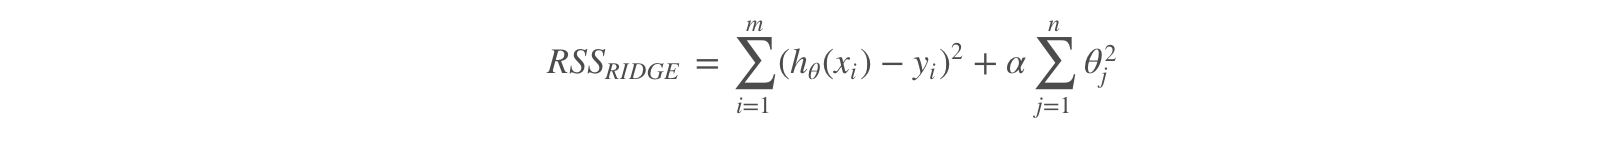

En changeant la valeur α nous pouvons contrôler l'importance de la régularisation. Lorsque nous augmentons α la régularisation augmente et l'inverse est également valable. 
En conséquence, on a sélectionné différentes valeurs de α et on s’est servis de notre régression linéaire sans régularisation afin d'observer facilement les différences.



In [110]:
features = data.drop('price' , axis=1)
target = data['price']
X_train , X_test , y_train , y_test = train_test_split(features , 
                                                       target , test_size=0.15 , shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
lis_evaluate = []

def model_prediction(model , model_name) : 
    
    model.fit(X_train , y_train)
    prediction = model.predict(X_test)
    
    r2 = r2_score(prediction , y_test)
    mae = mean_absolute_error(prediction , y_test).round(2)
    
    print(f'{model_name} R2 = {r2}')
    print(f'{model_name} MAE = {mae}')
    lis_evaluate.append([model_name , r2 , mae])

In [111]:
model_prediction(LinearRegression() , 'LinearRegression()')

LinearRegression() R2 = 0.5342668091363357
LinearRegression() MAE = 124866.61


In [116]:
model_prediction(Ridge() , 'Ridge')

Ridge R2 = 0.5342417140536792
Ridge MAE = 124864.27



 <h4><center>Regression Lasso</center></h4> 

La régression Lasso est appelée régularisation L1 et elle est définie comme suit

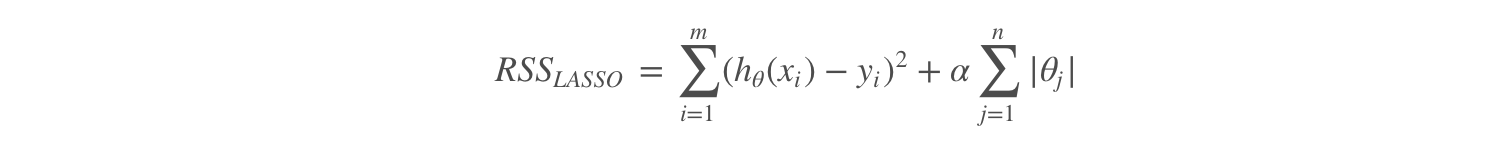

La principale différence entre le ridge et le lasso est la pénalité, mais α fonctionne de la même manière.


In [113]:
model_prediction(Lasso() , 'Lasso')

Lasso R2 = 0.5342672126055739
Lasso MAE = 124866.56


In [114]:
result = pd.DataFrame(lis_evaluate , columns=['Model' , 'R2' , 'MAE']).sort_values('R2' , ascending=False)
result

,Model,R2,MAE
2,Lasso,0.534267,124866.56
0,LinearRegression(),0.534267,124866.61
1,Ridge,0.534242,124864.27


Les résultats sont très proches. La régression linéaire sans régularisation semble avoir le meilleur rapport entre MAE et R2.

 <h3><center>Autres modèles de régression : SVR, XGBoost, Bagging, Gradient Boosting, Decision Tree</center></h3> 
 
### Scores et Temps d'execution

In [115]:
rfr = RandomForestRegressor()
svr = SVR(kernel="rbf")
xgb = XGBRegressor()
br = BaggingRegressor()
gb = GradientBoostingRegressor()
dtr = DecisionTreeRegressor()

Regressors = [br,gb,rfr,svr,xgb,dtr]
accuracy=[]
timeTaken=[]
for model in Regressors:
    start = time.time()
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy.append(r2_score(y_test,y_pred))
    end = time.time()
    timeTaken.append((end-start) * 10**3)

name =[]
for i in Regressors :
     name.append(i.__class__.__name__) 
data = {'Algorithm': name , 'Score': accuracy, 'Time taken' : timeTaken}
result = pd.DataFrame(data).sort_values('Score' , ascending=False)
result

,Algorithm,Score,Time taken
4,XGBRegressor,0.899981,2543.339491
2,RandomForestRegressor,0.873856,21449.525833
0,BaggingRegressor,0.872846,1786.795855
1,GradientBoostingRegressor,0.844265,3898.626089
5,DecisionTreeRegressor,0.738910,367.993832
3,SVR,-0.046411,22380.646467


On voit que le RandomForestRegressor a le meilleur score : 88% de précision. Cependant, il prend un temps d'execution bien plus important. 
Au contraire, en voulant minimiser le temps, on perd grandement en précision : voir l'arbre de décision. 

Il faut trouver un compromis, et cela semble ce trouver dans le XGBRegressor. 

<h3><center>learning curve des modèles : cas de XGBRegressor</center></h3>  

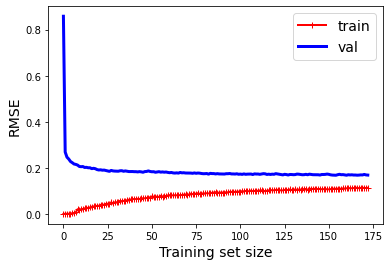

In [27]:
def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train),100):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)     
    
plot_learning_curves(XGBRegressor(),features,target)

En faisant une ACP, l'objectif était presque similaire à nos algorithmes de sélection de variables antérieurs. Il était de voir si en se débarrassant de certaines variables, on aurait des résultats intéressants. Cela n'a pas été le cas. Nous poursuivons donc avec gridSearch et la validation croisée.


En utilisant simplement les paramètres par défaut, nous sommes en mesure d'obtenir un score maximal d'environ 88%. En effectuant cette gridSearchCV, nous espérons trouver les meilleurs hyperparamètres et optimiser notre score, notamment pour le random Forest et XGBoost, qui se sont avérés plus intéressants. 

<h2><center>Analyse en Composante Principale</center></h2>  


**Principale motivation** :  Faut-il dégager certaines variables ?

L'analyse en composantes principales (ACP) permet de réduire le nombre de dimensions d'un jeu de données décrit par un grand nombre de variables. Cela permet une visualisation simplifiée et une accélération des calculs.

Il est vrai qu'on a pas un nombre assez important de variables mais pour une application du cours, on va s'amuser à le faire!!!


In [68]:
features_centred = scaler.fit_transform(features)
pca = PCA(n_components=14)
X_pca = pca.fit_transform(features_centred)

In [79]:
print(pca.singular_values_)

[336.17652698 218.12353318 199.68128358 171.81345514 161.41515062
 147.23256437 137.38001284 134.43506246 119.19842065 113.98110635
 103.8108801   93.49805003  83.78850451  78.52733284]


In [80]:
print(pca.components_) 

[[ 2.46351747e-01  3.64256998e-01  3.94826377e-01  1.04416009e-01
   2.36703292e-01  4.60816743e-02  1.12841387e-01 -8.64162890e-02
   3.67614929e-01  3.93105742e-01  8.38216579e-02  2.53105189e-01
   2.02307531e-03 -1.61413071e-01 -3.74730477e-03  1.88793665e-01
   3.55855123e-01  1.11241918e-01]
 [ 1.64259784e-01  8.85942832e-02  1.96031798e-01 -1.43449865e-01
  -1.35896559e-01  2.10314591e-01  3.44723111e-01  2.03094279e-01
   9.04539635e-02 -1.89094807e-02  4.42190300e-01 -3.29295669e-01
   1.82091350e-01  3.34901214e-01  2.35728682e-01 -3.75610331e-01
   8.03339411e-02 -1.49846222e-01]
 [-9.56387350e-03 -1.09932335e-01  3.82562165e-02  5.47131960e-01
  -3.36075788e-01  1.10271038e-01  1.59218014e-01  2.41210767e-01
  -9.25627378e-02 -5.24075118e-02  1.77448464e-01 -2.02172795e-01
   5.11417514e-02 -1.61915004e-01 -1.65687477e-01  1.73451446e-01
   4.86182770e-02  5.53133994e-01]
 [-3.37384447e-01 -5.44563946e-02 -9.36292750e-02  2.52414102e-01
   2.98756356e-01  3.55079181e-01  2.

In [81]:
print(f"La variance expliquée par composante :{pca.explained_variance_ratio_}")
total_explained_variance = pca.explained_variance_ratio_.sum()
print(f"La variance totale expliquée :{total_explained_variance}")

La variance expliquée par composante :[0.29050072 0.12229747 0.10249134 0.07587991 0.0669732  0.05572117
 0.04851316 0.04645554 0.03652191 0.03339475 0.02770117 0.02247075
 0.01804602 0.01585091]
La variance totale expliquée :0.9628180055523771


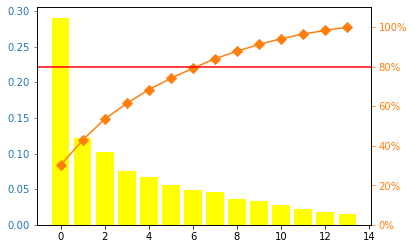

In [82]:
def visualisation(data) :
    from matplotlib.ticker import PercentFormatter
    import numpy as np
    y = list(data)
    x = range(len(data))
    ycum = np.cumsum(y)/sum(y)*100
    fig, ax = plt.subplots()
    ax.bar(x,y,color="yellow")
    ax2 = ax.twinx()
    ax2.plot(x,ycum, color="C1", marker="D", ms=7)
    ax2.axhline(y=80,color="r")
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.tick_params(axis="y", colors="C0")
    ax2.tick_params(axis="y", colors="C1")
    plt.ylim(0,110)
    plt.show()
visualisation(pca.explained_variance_ratio_)

Plus le nombre de composantes grandit, moins la variance expliquée par la composante ajoutée est.


La variance expliquée par les *14* composantes est de :0.9628180055523771

 <h2><center>Quelques pipelines pour combinants ACP et quelques algorithmes</center></h2>  
 

In [117]:
xgbr_pipe = Pipeline([
 ('pca', PCA()),
 ('xgbr', XGBRegressor())])

rdf_pipe = Pipeline([
 ('pca', PCA()),
 ('rfr', RandomForestRegressor())])

gbr_pipe = Pipeline([
 ('pca', PCA()),
 ('gbr', GradientBoostingRegressor())])
    

svr_pipe = Pipeline([
 ('pca', PCA()),
 ('svr', SVR())])


br_pipe=svr_pipe = Pipeline([
 ('pca', PCA()),
 ('svr', BaggingRegressor())])


pipes = [xgbr_pipe,gbr_pipe,svr_pipe,rdf_pipe,br_pipe]
accuracy=[]
for model in pipes:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy.append(r2_score(y_test,y_pred))

names =["XGBRegressor","GradientBoosting","svr","RandomForestRegressor","BaggingRegressor"]
data = {'Algorithm': names , 'Score': accuracy }
result = pd.DataFrame(data)
result.sort_values('Score' , ascending=False)

,Algorithm,Score
3,RandomForestRegressor,0.823307
2,svr,0.819357
4,BaggingRegressor,0.797060
0,XGBRegressor,0.793415
1,GradientBoosting,0.791418


Résultat : ça n’a pas amélioré les scores. voire ça a donné un résultat moins intéressant. Cela, encore une fois, est assez aisé à comprendre, étant donné que l’on n’a pas beaucoup de variables explicatives à l’origine.  

<h2><center>Raffinement des hyper-paramètres pour le modèle Random Forest</center></h2>


Nous allons maintenant utiliser gridsearchCV pour trouver les meilleurs hyperparamètres et optimiser les scores obtenus.

<h2><center>Grid Search pour Random Forest</center></h2>

Grid search est un algorithme de recherche exhaustif en cela qu’il évalue toutes les combinaison d’hyperparamètres dans un espace de recherche que l’on a prédéfini. Donc quand il y en a beaucoup, ça peut prendre du temps.

In [ ]:
param_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rfr = GridSearchCV(rfr , param_grid = param_rf ,cv =5)
grid_rfr.fit(X_train,y_train)


print("parameters for Random Forest:", grid_rfr.best_params_)

<h2><center> Random Search pour le modèle Random Forest</center></h2>

Random Search sélectionne aléatoirement certaines combinaisons d’hyperparamètres parmi l’ensemble des combinaisons possibles. Donc en un temps limité, une plus large variété de combinaisons peut être testée. À défaut parfois de la meilleure combinaison, qui peut ne pas se trouver dans la sélection.



In [ ]:
rfr = RandomForestRegressor(min_samples_leaf= 2, n_estimators= 350)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print(r2_score(y_test,y_pred))

param_grid = { 
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    "max_depth": range(3,21,3),
    "gamma": [i/10.0 for i in range(0,9)],
    "colsample_bytree": [i/10.0 for i in range(3,5)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}


random_search = RandomizedSearchCV(estimator=xgb, 
                           param_distributions=param_grid, 
                           n_iter=48, 
                           n_jobs=-1, 
                           cv=2, 
                           verbose=0)
random_result = random_search.fit(X_train, y_train)

random_result

print(f'The best score is {random_result.best_score_:.4f}')
print(f'The best hyperparameters are {random_result.best_params_}')
random_predict = random_search.predict(X_test)

score= r2_score(y_test, random_predict)
print(f'The score for the xgboost random search is {score}')

space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

def objective(params):
    rfr = RandomForestRegressor(min_samples_leaf= 2, n_estimators= 350)     
    scores = cross_val_score(rfr, X_train, y_train, cv=2, scoring='r2', n_jobs=-1)
    best_score = max(scores)
    loss = - best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

print(space_eval(space, best))## Bayesian Optimization Hyperopt pour le modèle Random Forest 

L’optimisation Bayésienne utilise les résultats de l’étape précédente pour décider quelle combinaison d’hyper-paramètres elle va tester ensuite. À la différence de Grid/Random search, l’optimisation Bayésienne ne considère pas les combinaisons d’hyper-paramètres indépendamment les uns des autres.


In [ ]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

def objective(params):
    rfr = RandomForestRegressor(min_samples_leaf= 2, n_estimators= 350)     
    scores = cross_val_score(rfr, X_train, y_train, cv=2, scoring='r2', n_jobs=-1)
    best_score = max(scores)
    loss = - best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

print(space_eval(space, best))

In [ ]:
rfr_bo = RandomForestRegressor(colsample_bytree = 0.6, 
                               gamma = 0.0, 
                               learning_rate = 0.01, 
                               max_depth = 15, 
                               reg_alpha = 0.01, 
                               reg_lambda = 1e-05).fit(X_train,y_train)
                          
bayesian_opt_predict = rfr_bo.predict(X_test)
score = r2_score(y_test, bayesian_opt_predict)
print(f"Le r2_score pour l'optimisation Bayésienne de la Random Forest est {score}")

<h2><center> Optimisation bayésienne pour le modèle XGBoost</center></h2>


In [ ]:
space = {
    'learning_rate': hp.choice('learning_rate', [0.0001,0.001, 0.01, 0.1, 1]),
    'max_depth' : hp.choice('max_depth', range(3,21,3)),
    'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
    'colsample_bytree' : hp.choice('colsample_bytree', [i/10.0 for i in range(3,10)]),     
    'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 10, 100]), 
    'reg_lambda' : hp.choice('reg_lambda', [1e-5, 1e-2, 0.1, 1, 10, 100])
}

def objective(params):
    xg = XGBRegressor(seed=0, **params)
    scores = cross_val_score(xgb, X_train, y_train, cv=2, scoring='r2', n_jobs=-1)
    best_score = max(scores)
    loss = - best_score
    return {'loss': loss, 'params': params, 'status': STATUS_OK}
bayes_trials = Trials()
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = 48, trials = bayes_trials)

xgboost_bo = XGBRegressor(seed=0, 
                           colsample_bytree=0.8, 
                           gamma=0.4, 
                           learning_rate=0.1, 
                           max_depth=12, 
                           reg_alpha=0.01,
                           reg_lambda=10
                           ).fit(X_train,y_train)
                          
bayesian_opt_predict = xgboost_bo.predict(X_test)
score = r2_score(y_test, bayesian_opt_predict)
print(f"Le r2_score pour l'optimisation Bayésienne de la Random Forest est{score}")

On voit que les scores sont améliorés.

<h2><center> Réseau de neurones </center></h2>

In [54]:
import tensorflow as tf 
model = tf.keras.Sequential([tf.keras.layers.InputLayer(
    input_shape=18,),
  tf.keras.layers.Dense(20, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation = tf.keras.activations.relu),
  tf.keras.layers.Dense(1)
])

start = time.time()
model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

history=model.fit(X_train, y_train,          
          validation_data=(X_test,y_test),
          batch_size=128,
          epochs=100)
end = time.time()

timeTaken1 = end-start

Epoch 1/100
144/144 [==============================] - 1s 4ms/step - loss: 57.1437 - mae: 6.0223 - val_loss: 6.3514 - val_mae: 1.9080
Epoch 2/100
144/144 [==============================] - 0s 2ms/step - loss: 4.1086 - mae: 1.4867 - val_loss: 2.6769 - val_mae: 1.1666
Epoch 3/100
144/144 [==============================] - 0s 2ms/step - loss: 2.0580 - mae: 1.0476 - val_loss: 1.6411 - val_mae: 0.9127
Epoch 4/100
144/144 [==============================] - 0s 2ms/step - loss: 1.2857 - mae: 0.8286 - val_loss: 1.0714 - val_mae: 0.7357
Epoch 5/100
144/144 [==============================] - 0s 2ms/step - loss: 0.8418 - mae: 0.6730 - val_loss: 0.7453 - val_mae: 0.6142
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5733 - mae: 0.5534 - val_loss: 0.5236 - val_mae: 0.5091
Epoch 7/100
144/144 [==============================] - 0s 2ms/step - loss: 0.4001 - mae: 0.4602 - val_loss: 0.3728 - val_mae: 0.4242
Epoch 8/100
144/144 [==============================] - 0s 2ms/step -

In [ ]:
start = time.time()
preds = model.predict(X_test)
print('R score is :', r2_score(y_test, preds))

In [ ]:
start = time.time()
y_pred = model.predict(X_test)
end = time.time()
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
print('R score is :', r2_score(y_test, y_pred))
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
plt.plot(y_test,y_test,'b')
timeTaken2 = end - start
print('Time taken for train:',timeTaken1))
print('Time taken for prediction:',timeTaken2))

Pour les réseaux de neurones, le score est assez faible par rapport aux autres. Cela n'est pas étonnant puisqu'on travaille sur une base de données tabulée de taille relativement moyenne, là où les réseaux de neurones apportent un réel avantage pour les données non structurées (données multimédia : images, données météo ou géospatiales, etc.)

<h2><center> Conclusion et perspectives </center></h2>


Nous avons conscience qu'il n'y a pas de meilleur modèle à proprement parler. Tous pourraient être utiles selon la situation dans laquelle on s'inscrit. Le nombre de données, par exemple, rend plus ou moins important le critère de temps d'execution. Ici, pour moins de 20000 données, nous pourrions prendre le Random Forest sans que cela soit trop couteux. Mais dans un cadre plus industriel, XGBoost avec tels paramètres semble être le meilleur. 

Tout au long de cette étude, nous nous sommes employés à estimer la valeur des logements à partir des données sur les caractéristiques du parc immobilier de la région. Cependant, cette procédure ne tient pas compte du prix des maisons voisines, qui est une source d'information potentiellement importante – des corrélations existant entre les prix des maisons et celles de leurs voisines. On pourrait ajouter à notre objectif celui de savoir en quoi les corrélations existant entre les prix des maisons voisines peuvent être incorporées lors de la prédiction des prix des maisons. Représentent-elles un indicateur fiable ? Voilà à nos yeux une question qui vaudrait la peine d'être explorée. 